In [ ]:
#hide
#all_slow

In [ ]:
#hide
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastcore --upgrade

# Training EfficientNet-UNET

> Training notebook for this architecture.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/nbs/11_resnet18-UNET.ipynb)

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from steel_segmentation.all import *

import cv2
import fastai
import torch
import numpy as np
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

import albumentations as alb
import segmentation_models_pytorch as smp

In [ ]:
device = torch.device("cpu")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); device

device(type='cuda')

In [ ]:
fastai.__version__, torch.__version__

('2.3.0', '1.7.1+cu101')

In [ ]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Mon May  3 19:50:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   30C    P8    11W / 120W |      4MiB /  8126MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#hide
seed_everything()

## Data

In [ ]:
cond = train_pivot[0] != -1 # no common hard negatives
df = train_pivot.loc[cond]
df.shape

(6666, 6)

In [ ]:
def get_train_aug(height, width, with_gray=False): 
    #alb.CropNonEmptyMaskIfExists(height, width, p=0.5), #added after stage-1
    first_step = alb.RandomCrop(height, width, p=1.0)
    
    second_step = alb.OneOf([alb.VerticalFlip(p=0.5),
                              alb.HorizontalFlip(p=0.5)
                             ], p=0.5)
    
    third_step = alb.OneOf([
        alb.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), 
                                     contrast_limit=(-0.2, 0.2), 
                                     brightness_by_max=True,
                                     p=0.5),
        alb.RandomGridShuffle(always_apply=False, p=0.2, grid=(1, 2))], p=0.5)
    
    # to do: try with grayscale imgs
    gray_step = alb.ToGray(always_apply=False, p=1.0)
    return alb.Compose([first_step, second_step, third_step] + ([gray_step] if with_gray else []))

def get_valid_aug(height, width, with_gray=False): 
    first_step = alb.RandomCrop(height, width)
    gray_step = alb.ToGray(always_apply=False, p=1.0)
    return alb.Compose([first_step] + ([gray_step] if with_gray else []))

In [ ]:
size = (224,1568)
# size = (128,896)

In [ ]:
train_tfms = get_train_aug(*size)
valid_tfms = get_valid_aug(*size)

In [ ]:
block = DataBlock(blocks = (ImageBlock,SteelMaskBlock(codes=[1,2,3,4])),
                  get_x = ReadImagePathFromIndex,
                  get_y = ReadRLEs(cols=[1,2,3,4]),
                  splitter = TrainTestSplitter(test_size=0.2),
                  item_tfms=[AlbumentationsTransform(train_tfms, valid_tfms)],
                  batch_tfms=[Normalize.from_stats(*imagenet_stats)])

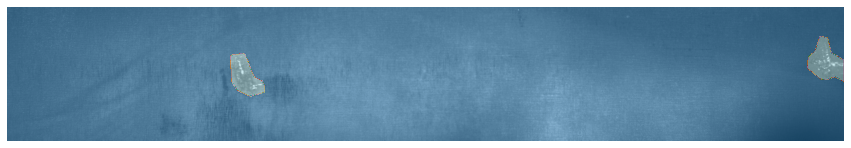

In [ ]:
ds = block.datasets(df)

img, mask = ds.valid[1]
ax = img.show(figsize=(15,5))
mask.show(ctx=ax);

## SMP - Training

In [ ]:
dls = block.dataloaders(source=df, 
                        bs=8, 
                        device=device, 
                        num_workers=0)

Could not do one pass in your dataloader, there is something wrong in it


In [ ]:
x,y = dls.valid.one_batch()
x.shape, y.shape

(torch.Size([8, 3, 224, 1568]), torch.Size([8, 4, 224, 1568]))

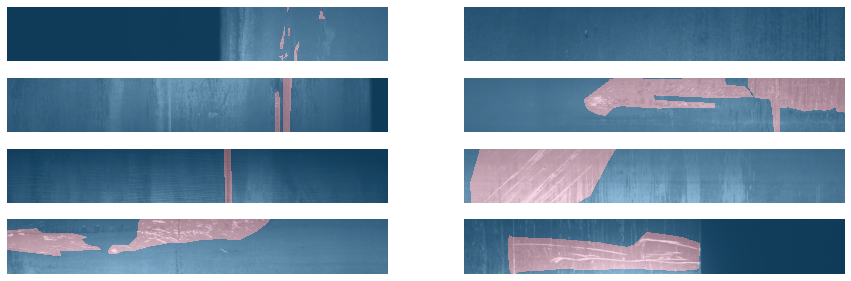

In [ ]:
dls.show_batch(ncols=2, figsize=(15,5))

In [ ]:
arch = smp.Unet('efficientnet-b2', classes=4, activation=None, 
                encoder_weights='imagenet')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


In [ ]:
# to load the weights into the arch use
arch.load_state_dict(torch.load(models_dir/("efficientnet_b2-UNET-stage0.pth")))

<All keys matched successfully>

![UNET Architecture](../imgs/unet.png)

In [ ]:
def opt_func(params, **kwargs): return OptimWrapper(params, torch.optim.Adam, **kwargs)
def splitter(m): return convert_params([[m.encoder], [m.decoder], [m.segmentation_head]])

In [ ]:
learn = Learner(dls=dls, 
                model=arch, 
                loss_func=BCEWithLogitsLossFlat(axis=1),
                metrics=[ModDiceMulti(with_logits=True)], 
                splitter=splitter, 
                opt_func=opt_func, 
                model_dir=models_dir,
                path=models_dir,
                cbs=[CudaCallback(), ShowGraphCallback()]).to_fp16()

In [ ]:
#learn.freeze_to(-2)
learn.unfreeze()

In [ ]:
learn.summary()

Unet (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     []                  
ZeroPad2d                                                      
BatchNorm2d                               64         True      
____________________________________________________________________________
                     []                  
ZeroPad2d                                                      
BatchNorm2d                               64         True      
Identity                                                       
Identity                                                       
Identity                                                       
BatchNorm2d                               32         True      
MemoryEfficientSwish                                           
ZeroPad2d                                                      
BatchNorm2d                               32         True      
Identity                                         

Due to misconception I previously trained the model without augmentations.

In [ ]:
stage = "efficientnet_b2-UNET-stage0"

In [ ]:
fit_cbs = [
    GradientAccumulation(n_acc=16),
    ReduceLROnPlateau(monitor='valid_loss', patience=2),
    CSVLogger(fname=f'{models_dir}/logs/{stage}.csv'),
    SaveModelCallback(monitor='valid_loss', fname=stage)]

epoch,train_loss,valid_loss,mod_dice_multi,time
0,0.513457,0.393795,0.252899,04:41
1,0.290152,0.188096,0.286804,04:29
2,0.153328,0.104251,0.388386,04:29
3,0.090937,0.067388,0.403346,04:29
4,0.062011,0.048192,0.506705,04:29


Better model found at epoch 0 with valid_loss value: 0.3937946557998657.


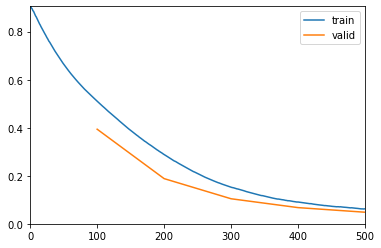

Better model found at epoch 1 with valid_loss value: 0.18809622526168823.
Better model found at epoch 2 with valid_loss value: 0.10425052791833878.
Better model found at epoch 3 with valid_loss value: 0.06738794595003128.
Better model found at epoch 4 with valid_loss value: 0.04819217696785927.


In [ ]:
#test
learn.dls = block.dataloaders(df.iloc[:1000], bs=8, num_workers=0)
learn.fit(5, lr=4e-4, cbs=fit_cbs)

After this test, you need to reload the notebook.

epoch,train_loss,valid_loss,mod_dice_multi,time
0,0.197872,0.150238,0.492619,30:29
1,0.045045,0.041623,0.623954,29:58
2,0.027921,0.027541,0.601422,29:49
3,0.022508,0.024429,0.596927,29:42
4,0.019809,0.019002,0.633043,29:49
5,0.018687,0.020704,0.631026,29:56
6,0.016174,0.018414,0.635311,29:48
7,0.014258,0.018302,0.623572,29:44
8,0.012443,0.018229,0.636347,29:48
9,0.010727,0.018082,0.638715,30:09


Better model found at epoch 0 with valid_loss value: 0.150238037109375.


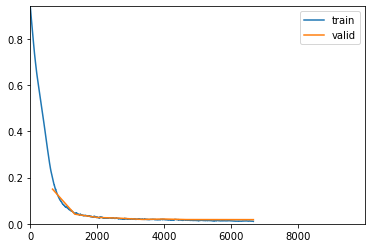

Better model found at epoch 1 with valid_loss value: 0.04162340238690376.
Better model found at epoch 2 with valid_loss value: 0.027541441842913628.
Better model found at epoch 3 with valid_loss value: 0.02442856691777706.
Better model found at epoch 4 with valid_loss value: 0.019001780077815056.
Better model found at epoch 6 with valid_loss value: 0.018414458259940147.
Better model found at epoch 7 with valid_loss value: 0.0183021891862154.
Better model found at epoch 8 with valid_loss value: 0.018228640779852867.
Better model found at epoch 9 with valid_loss value: 0.018082445487380028.


In [ ]:
learn.fit_one_cycle(15, lr_max=5e-4, div=5., cbs=fit_cbs)

The training was interrupted by paperspace time constrain. So I reload the best model founded in the last epoch.

In [ ]:
stage = "efficientnet_b2-UNET-stage0"
loaded_learn = learn.load(stage)

## Results

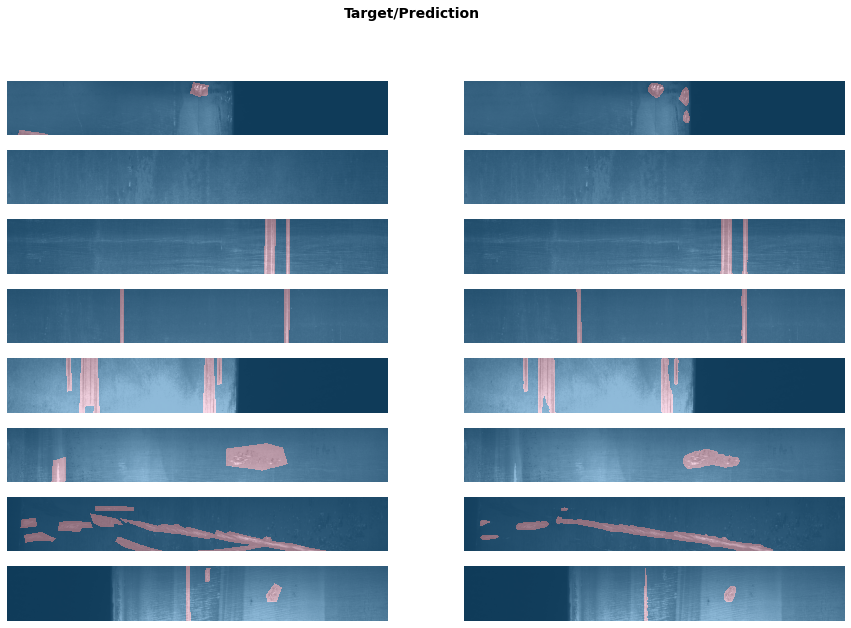

In [ ]:
learn.show_results(figsize=(15,10))

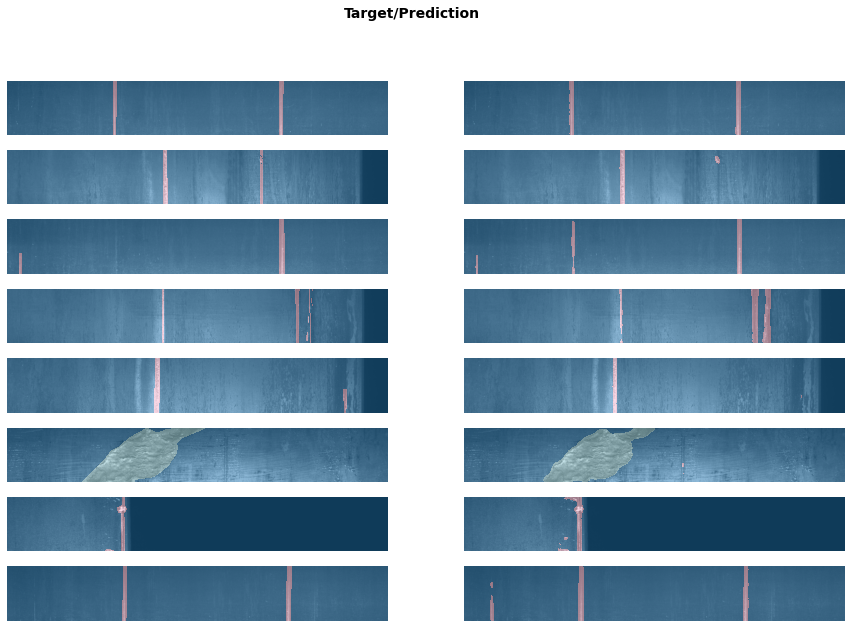

In [ ]:
learn.show_results(figsize=(15,10))

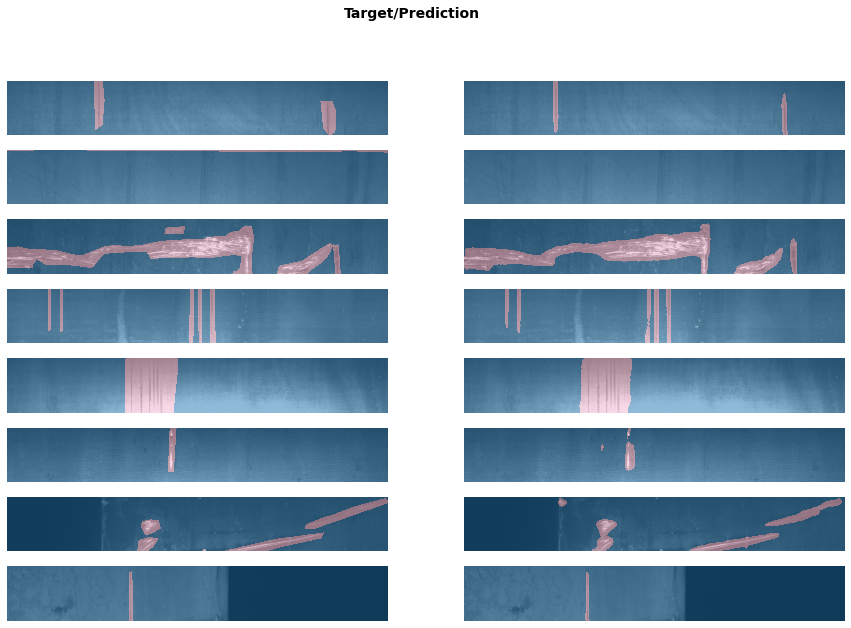

In [ ]:
learn.show_results(figsize=(15,10))

## Deployment

Export the learner for inference:

In [ ]:
block_exp = DataBlock(blocks = (ImageBlock,SteelMaskBlock(codes=[1,2,3,4])),
                  get_x = ReadImagePathFromIndex,
                  get_y = ReadRLEs(cols=[1,2,3,4]),
                  splitter = TrainTestSplitter(test_size=0.2))
dls_exp = block_exp.dataloaders(source=df, bs=8, device=device, num_workers=0)
learn_exp = Learner(dls=dls_exp, 
                    model=arch, 
                    loss_func=BCEWithLogitsLossFlat(axis=1),
                    metrics=[ModDiceMulti(with_logits=True)], 
                    splitter=splitter, 
                    opt_func=opt_func, 
                    model_dir=models_dir,
                    path=models_dir)
stage = "efficientnet_b2-UNET-stage0"
learn_exp.model = learn_exp.load(stage, device=device).cpu()
learn_exp.export("exports/efficientnet-b2.pkl")

Could not do one pass in your dataloader, there is something wrong in it


Checking to the exported learner:

In [ ]:
loaded_learn_pkl = load_learner(models_dir/"exports"/"efficientnet-b2.pkl", cpu=True)

In [ ]:
loaded_learn_pkl.validate()

(#2) [0.01974334567785263,0.6359560701732629]

In [ ]:
rles, preds, probs = loaded_learn_pkl.predict(img)

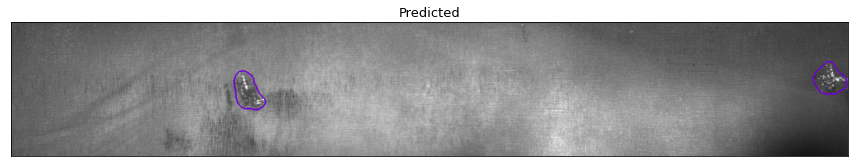

In [ ]:
plot_mask_image("Predicted", np.array(img), preds.permute(1,2,0).float().numpy())